Task Description:
Entropy Calculation:
The assistant needs to compute the entropy for both bigrams and trigrams separately for each quantum assembly language file and for the entire set of files. The entropy should be computed based on the instructions in each file, with two different methods for handling instructions:

Full Instruction: The assistant considers the entire line as one instruction (including the operation name and parameters).
Stripped Instruction: The assistant strips away the parameters and only considers the operation name for calculating the entropy.
File Chunking:
The quantum assembly files contain a prologue with definitions (e.g., open cousin, register, custom gate declarations). The assistant should automatically detect the end of this prologue and focus only on the instructions part of the code. It should ignore the initial definitions and register parts and then process the subsequent lines (the instructions).

N-gram Calculation:
The assistant should calculate the entropy using n-grams. The user provides a list of integers specifying the n-gram sizes, with a default of [2, 3] for bigrams and trigrams. The n-gram frequencies should be counted only based on the instructions found in the files, and entropy is calculated separately for each n-gram size.

Output Format:

CSV File (File-level entropy): The output should be a CSV file where each row corresponds to a file and includes the file name and entropy values for both bigrams and trigrams.
Format: file_name, bigram_entropy, trigram_entropy
The entropy values should be raw floating point numbers.
JSON File (Set-level entropy): The output should also include a JSON file that contains:
The set-level entropy for both bigrams and trigrams.
The average file-level entropy for both bigrams and trigrams.
The structure of the JSON file can be flexible, but should be clear and logical.
In case of edge cases (files with very few or incomplete instructions), the entropy should be reported as null or 0 (not skipped).
Edge Cases:
For files with insufficient data (e.g., very few instructions or incomplete instructions), the assistant should report null or 0 as the entropy value, rather than skipping those files.

Output Specifications:
CSV Output: Each row will contain:
file_name: Name of the quantum assembly file.
bigram_entropy: Entropy for bigrams.
trigram_entropy: Entropy for trigrams.
JSON Output: The JSON will contain:
set_level: Set-level entropy values for both bigrams and trigrams.
avg_file_level: Average file-level entropy values for both bigrams and trigrams.
Handle edge cases gracefully with null or 0 for files with insufficient instructions.

In [4]:
import os
import math
import json
import csv
from collections import Counter
import glob
from multiprocessing import Pool, cpu_count
from functools import partial


def calculate_entropy(data):
    """Calculates the entropy of a data sequence."""
    if not data:
        return 0.0
    probabilities = [n_x / len(data) for x, n_x in Counter(data).items()]
    entropy = -sum(p * math.log2(p) for p in probabilities)
    return entropy


def process_qasm_file(file_path, n_grams=[2, 3], strip_params=False):
    """
    Processes a single QASM file to calculate entropy for n-grams.

    Args:
        file_path (str): Path to the QASM file.
        n_grams (list): List of n-gram sizes to calculate entropy for.
        strip_params (bool): Whether to strip parameters from instructions.

    Returns:
        dict: A dictionary containing the file name and entropy values for each n-gram size.
    """
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Identify the end of the prologue (definitions and register parts)
        instruction_start_index = -1
        for i, line in enumerate(lines):
            if not line.strip() or line.strip().startswith(('//', '#')):
                continue
            parts = line.split()
            if len(parts) > 0 and parts[0] in ['OPENQASM', 'include', 'gate',
                                               'opaque', 'def']:
                continue
            if len(parts) > 1 and parts[0] in ['qreg', 'creg', 'param']:
                continue
            instruction_start_index = i
            break

        instructions = [line.strip()
                        for line in lines[instruction_start_index:]
                        if line.strip() and not line.strip().startswith(
                            ('//', '#'))]
        # print("instructions: ", instructions)
        if strip_params:
            instructions = [line.split()[0] for line in instructions]
            instructions = [line.split('(')[0] for line in instructions]
            # print("(stripped) instructions: ", instructions)

        entropies = {}
        for n in n_grams:
            n_grams_list = [
                tuple(instructions[i: i + n])
                for i in range(len(instructions) - n + 1)]
            # print("n_grams_list: ", n_grams_list)
            entropies[f'n{n}_gram_entropy'] = calculate_entropy(
                n_grams_list) if n_grams_list else 0.0

        return {'file_name': os.path.basename(file_path), **entropies, 'n_instructions': len(instructions)}

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return {'file_name': os.path.basename(file_path), **{f'n{n}_gram_entropy': None for n in n_grams}, 'n_instructions': 0}


def process_directory(
        directory_path, n_grams=[2, 3],
        strip_params=False, compute_in_parallel=True):
    """
    Processes all QASM files in a directory.

    Args:
        directory_path (str): Path to the directory containing QASM files.
        n_grams (list): List of n-gram sizes to calculate entropy for.
        strip_params (bool): Whether to strip parameters from instructions.
        compute_in_parallel (bool): Whether to process files in parallel.

    Returns:
        list: A list of dictionaries, where each dictionary contains the file name and entropy values for each n-gram size.
    """
    qasm_files = glob.glob(os.path.join(directory_path, "*.qasm"))

    process_file = partial(
        process_qasm_file, n_grams=n_grams, strip_params=strip_params)

    if compute_in_parallel:
        with Pool(cpu_count()) as pool:
            file_level_data = pool.map(process_file, qasm_files)
    else:
        file_level_data = [process_file(file) for file in qasm_files]

    return file_level_data


def calculate_set_level_entropy(file_level_data, n_grams=[2, 3, 4]):
    """
    Calculates the set-level entropy and average file-level entropy.

    Args:
        file_level_data (list): A list of dictionaries, where each dictionary contains the file name and entropy values for each n-gram size.
        n_grams (list): List of n-gram sizes to calculate entropy for.

    Returns:
        dict: A dictionary containing the set-level entropy and average file-level entropy for each n-gram size.
    """
    set_level = {}
    avg_file_level = {}

    for n in n_grams:
        all_n_grams = []
        for file_data in file_level_data:
            n_gram_key = f'n{n}_gram_entropy'
            if n_gram_key in file_data:
                # This part needs to reconstruct the n-grams from the file to calculate set-level entropy correctly.
                # For simplicity, we'll assume the instructions are concatenated across files.  This is a simplification.
                # A more accurate approach would require re-reading and processing each file.
                pass  # Replace with actual n-gram reconstruction if needed.

        # Since we don't have the actual n-grams, set-level entropy calculation is skipped.
        set_level[f'n{n}_gram_entropy'] = None

        # Calculate average file-level entropy
        valid_entropies = [file_data[f'n{n}_gram_entropy']
                           for file_data in file_level_data
                           if file_data[f'n{n}_gram_entropy'] is not None]
        avg_file_level[f'n{n}_gram_entropy'] = sum(
            valid_entropies) / len(valid_entropies) if valid_entropies else 0.0

    return {'set_level': set_level, 'avg_file_level': avg_file_level}


def write_csv_output(file_level_data, output_csv_path, n_grams=[2, 3, 4]):
    """
    Writes the file-level entropy data to a CSV file.

    Args:
        file_level_data (list): A list of dictionaries, where each dictionary contains the file name and entropy values for each n-gram size.
        output_csv_path (str): Path to the output CSV file.
        n_grams (list): List of n-gram sizes to calculate entropy for.
    """
    with open(output_csv_path, 'w', newline='') as csvfile:
        fieldnames = [
            'file_name'] + [f'n{n}_gram_entropy' for n in n_grams] + ['n_instructions']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for data in file_level_data:
            writer.writerow(data)


def write_json_output(set_level_data, output_json_path):
    """
    Writes the set-level entropy data to a JSON file.

    Args:
        set_level_data (dict): A dictionary containing the set-level entropy and average file-level entropy for each n-gram size.
        output_json_path (str): Path to the output JSON file.
    """
    with open(output_json_path, 'w') as jsonfile:
        json.dump(set_level_data, jsonfile, indent=4)

In [5]:
import tempfile


def test_qasm_full_instructions():
    qasm_content = """
    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[2];
    creg c[2];
    h q[0];
    rx(1.57) q[0];
    cx q[0], q[1];
    x q[1];
    x q[1];
    """
    with tempfile.NamedTemporaryFile(delete=False, suffix='.qasm') as temp_file:
        temp_file.write(qasm_content.encode())
        temp_file_path = temp_file.name

    result = process_qasm_file(
        temp_file_path, n_grams=[2, 3, 4],
        strip_params=True)
    print(result)


def test_qasm_stripped_instructions():
    qasm_content = """
    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[2];
    creg c[2];
    """
    with tempfile.NamedTemporaryFile(delete=False, suffix='.qasm') as temp_file:
        temp_file.write(qasm_content.encode())
        temp_file_path = temp_file.name

    result = process_qasm_file(
        temp_file_path, n_grams=[2, 3, 4],
        strip_params=True)
    print(result)


# Run the tests
test_qasm_full_instructions()
test_qasm_stripped_instructions()

{'file_name': 'tmpi9bi3ckd.qasm', 'n2_gram_entropy': 2.0, 'n3_gram_entropy': 1.584962500721156, 'n4_gram_entropy': 1.0, 'n_instructions': 5}
{'file_name': 'tmp8risw4zt.qasm', 'n2_gram_entropy': 0.0, 'n3_gram_entropy': 0.0, 'n4_gram_entropy': 0.0, 'n_instructions': 0}


In [13]:

# Replace with the path to your directory containing QASM files
directory_path = '../program_bank/v044/2025_03_03__22_08'  # 150 ops - qasm generator
# directory_path = '../program_bank/v043/2025_02_28__00_40'  # 15 ops
output_csv_path = 'file_level_entropy.csv'
output_json_path = 'set_level_entropy.json'
N_GRAMS = [2, 4, 8]

# Ensure the directory exists
if not os.path.exists(directory_path):
    print(f"Error: Directory '{directory_path}' not found.")
else:
    # Process files with full instructions
    file_level_data = process_directory(
        directory_path, n_grams=N_GRAMS, strip_params=False)
    set_level_data = calculate_set_level_entropy(
        file_level_data, n_grams=N_GRAMS)

    write_csv_output(file_level_data, output_csv_path, n_grams=N_GRAMS)
    write_json_output(set_level_data, output_json_path)

    print(f"File-level entropy written to '{output_csv_path}'")
    print(f"Set-level entropy written to '{output_json_path}'")

    # Process files with stripped instructions
    file_level_data_stripped = process_directory(
        directory_path, n_grams=N_GRAMS, strip_params=True)
    set_level_data_stripped = calculate_set_level_entropy(
        file_level_data_stripped, n_grams=N_GRAMS)

    write_csv_output(file_level_data_stripped,
                     'file_level_entropy_stripped.csv', n_grams=N_GRAMS)
    write_json_output(set_level_data_stripped,
                      'set_level_entropy_stripped.json')

    print(f"File-level entropy (stripped) written to 'file_level_entropy_stripped.csv'")
    print(f"Set-level entropy (stripped) written to 'set_level_entropy_stripped.json'")

File-level entropy written to 'file_level_entropy.csv'
Set-level entropy written to 'set_level_entropy.json'
File-level entropy (stripped) written to 'file_level_entropy_stripped.csv'
Set-level entropy (stripped) written to 'set_level_entropy_stripped.json'


In [14]:
from multiprocessing import Pool
from typing import Dict, Any
import pandas as pd
import re


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        return data


def read_all_jsons(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(
        dir_path) if re.match(r'.*\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)


df_metadata = read_all_jsons(os.path.join(directory_path, 'metadata'))
df_metadata["file_name"] = df_metadata["_filename"].str.replace(
    ".json", ".qasm")
df_metadata

,input_qasm,platform,round,importer_function,transformer_functions,exporter_function,importer_time,transformation_time,exporter_time,output_qasm,_filename,file_name
0,program_bank/v044/2025_03_03__22_08/0000301_qi...,qiskit,2,qiskit_import,[qiskit_change_gateset_u3_cx],qiskit_export,0.013505,[0.04754161834716797],0.031646,program_bank/v044/2025_03_03__22_08/0000301_qi...,0000301_qite_b0ff1e.json,0000301_qite_b0ff1e.qasm
1,program_bank/v044/2025_03_03__22_08/0000724_qi...,qiskit,5,qiskit_import,[qiskit_change_gateset_rx_ry_rz_cz],qiskit_export,0.044706,[0.25570058822631836],0.039165,program_bank/v044/2025_03_03__22_08/0000724_qi...,0000724_qite_ea4019.json,0000724_qite_ea4019.qasm
2,program_bank/v044/2025_03_03__22_08/0000070_9a...,pytket,1,pytket_import,[pytket_optimizer_peephole_2q],pytket_export,0.041318,[0.6233091354370117],0.043803,program_bank/v044/2025_03_03__22_08/0000070_qi...,0000070_qite_31fbd4.json,0000070_qite_31fbd4.qasm
3,program_bank/v044/2025_03_03__22_08/0000345_qi...,qiskit,5,qiskit_import,[qiskit_change_gateset_rx_ry_rz_cz],qiskit_export,0.396598,[0.5702483654022217],0.029400,program_bank/v044/2025_03_03__22_08/0000345_qi...,0000345_qite_55d347.json,0000345_qite_55d347.qasm
4,program_bank/v044/2025_03_03__22_08/0000230_16...,pytket,1,pytket_import,[pytket_optimizer_peephole_2q],pytket_export,0.033400,[0.6699554920196533],0.049262,program_bank/v044/2025_03_03__22_08/0000230_qi...,0000230_qite_7e4a66.json,0000230_qite_7e4a66.qasm
...,...,...,...,...,...,...,...,...,...,...,...,...
1758,program_bank/v044/2025_03_03__22_08/0000691_qi...,pytket,2,pytket_import,[pytket_change_gateset_Rz_SX_X_CX],pytket_export,0.106137,[0.023493289947509766],0.135199,program_bank/v044/2025_03_03__22_08/0000691_qi...,0000691_qite_578b05.json,0000691_qite_578b05.qasm
1759,program_bank/v044/2025_03_03__22_08/0000149_qi...,qiskit,4,qiskit_import,[qiskit_change_gateset_rx_ry_rz_cz],qiskit_export,0.037722,[0.2277686595916748],0.032785,program_bank/v044/2025_03_03__22_08/0000149_qi...,0000149_qite_cccae9.json,0000149_qite_cccae9.qasm
1760,program_bank/v044/2025_03_03__22_08/0000409_qi...,qiskit,4,qiskit_import,[qiskit_change_gateset_rx_ry_rz_cz],qiskit_export,0.013403,[0.24581623077392578],0.038305,program_bank/v044/2025_03_03__22_08/0000409_qi...,0000409_qite_0a3259.json,0000409_qite_0a3259.qasm
1761,program_bank/v044/2025_03_03__22_08/0000639_qi...,pytket,3,pytket_import,[pytket_optimizer_peephole_2q],pytket_export,0.312404,[0.8988394737243652],0.067094,program_bank/v044/2025_03_03__22_08/0000639_qi...,0000639_qite_5c6609.json,0000639_qite_5c6609.qasm


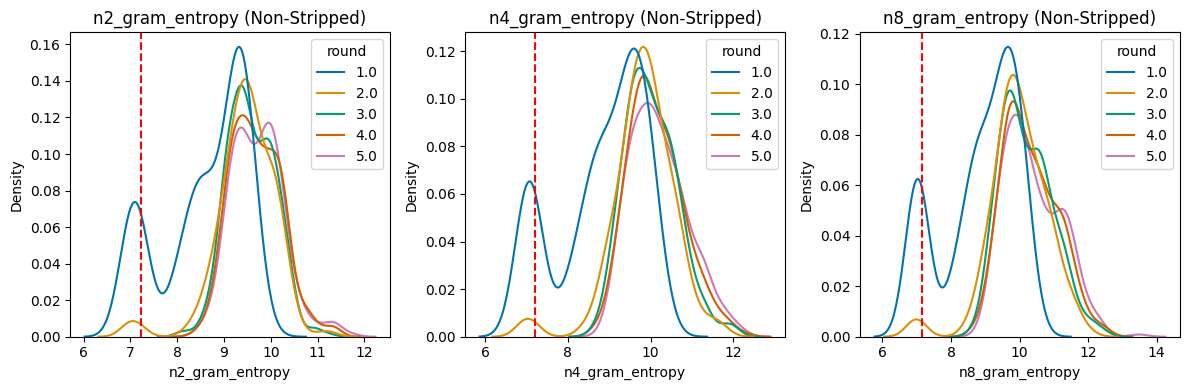

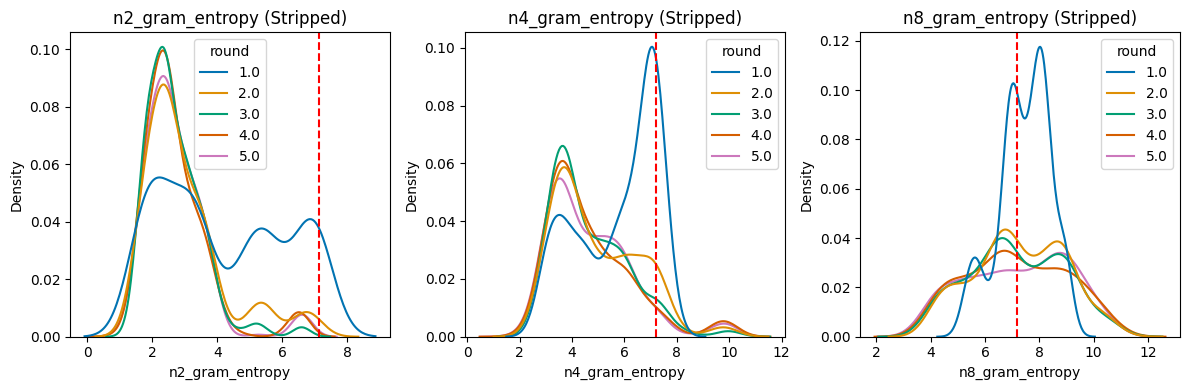

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


def read_and_merge_csv(file_path, metadata, fillna_value=0):
    df = pd.read_csv(file_path)
    df = df.merge(metadata, on='file_name', how='left')
    df['round'] = df['round'].fillna(fillna_value)
    df['is_transformed'] = df['file_name'].str.contains('_qite_')
    return df


def calculate_avg_entropy(df, round_value=0, n_grams=[2, 3, 4]):
    avg_entropies = {}
    for n in n_grams:
        avg_entropies[f'n{n}_gram_entropy'] = df[df['round']
                                                 == round_value][f'n{n}_gram_entropy'].mean()
    return avg_entropies


def plot_entropy_distribution(
        df, avg_entropies, title_suffix, n_grams=[2, 3, 4]):
    plt.figure(figsize=(4 * len(n_grams), 4))

    for i, n in enumerate(n_grams, 1):
        plt.subplot(1, len(n_grams), i)
        sns.kdeplot(data=df, x=f'n{n}_gram_entropy',
                    hue='round', palette='colorblind')
        plt.axvline(
            avg_entropies[f'n{n}_gram_entropy'],
            color='red', linestyle='--')
        plt.title(f'n{n}_gram_entropy ({title_suffix})')
        plt.xlabel(f'n{n}_gram_entropy')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()


# Reading and merging CSV files with metadata
df_file_level_entropy = read_and_merge_csv(
    'file_level_entropy.csv', df_metadata)
df_file_level_entropy_stripped = read_and_merge_csv(
    'file_level_entropy_stripped.csv', df_metadata)

# Calculating average entropy values
avg_entropies_non_stripped = calculate_avg_entropy(
    df_file_level_entropy, n_grams=N_GRAMS)
avg_entropies_stripped = calculate_avg_entropy(
    df_file_level_entropy_stripped, n_grams=N_GRAMS)

# Filtering only transformed files
df_file_level_entropy_only_qite = df_file_level_entropy[
    df_file_level_entropy['is_transformed'] == True]
df_file_level_entropy_stripped_only_qite = df_file_level_entropy_stripped[
    df_file_level_entropy_stripped['is_transformed'] == True]

# Plotting the distributions
plot_entropy_distribution(
    df_file_level_entropy_only_qite, avg_entropies_non_stripped,
    'Non-Stripped', N_GRAMS)
plot_entropy_distribution(
    df_file_level_entropy_stripped_only_qite, avg_entropies_stripped,
    'Stripped', N_GRAMS)

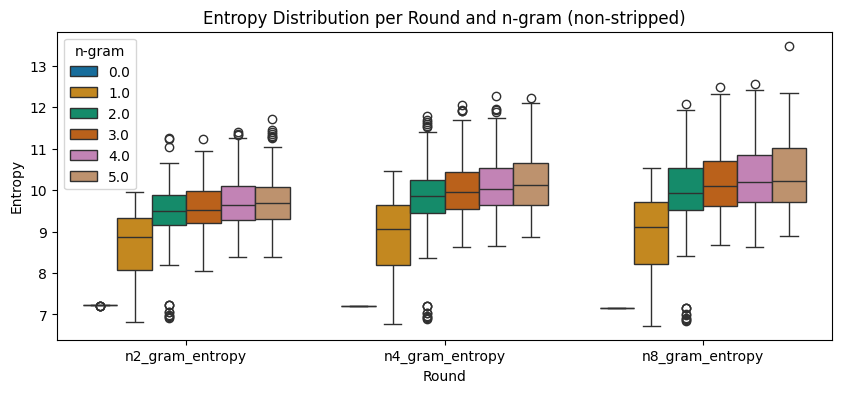

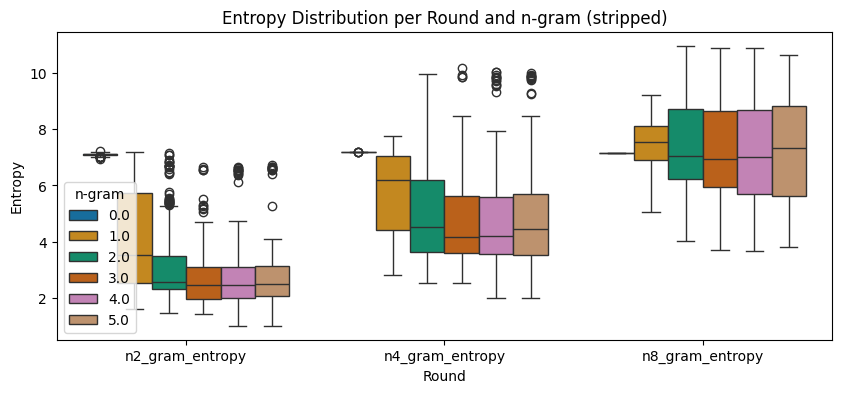

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt


# Repeat for stripped instructions
df_file_level_entropy = read_and_merge_csv(
    'file_level_entropy.csv', df_metadata)

# Keep only relevant columns round and n-gram entropies
columns_to_keep = ['round'] + [f'n{n}_gram_entropy' for n in N_GRAMS]
df_file_level_entropy = df_file_level_entropy[columns_to_keep]

df_file_level_entropy_melt = df_file_level_entropy.melt(
    id_vars=['round'], var_name='n_gram', value_name='entropy')

# Plot the boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_file_level_entropy_melt, x='n_gram',
            y='entropy', hue='round', palette='colorblind')
plt.xlabel('Round')
plt.ylabel('Entropy')
plt.title('Entropy Distribution per Round and n-gram (non-stripped)')
plt.legend(title='n-gram')
plt.show()


# Repeat for stripped instructions
df_file_level_entropy_stripped = read_and_merge_csv(
    'file_level_entropy_stripped.csv', df_metadata)

# Keep only relevant columns round and n-gram entropies
columns_to_keep = ['round'] + [f'n{n}_gram_entropy' for n in N_GRAMS]
df_file_level_entropy_stripped = df_file_level_entropy_stripped[columns_to_keep]

df_file_level_entropy_stripped_melt = df_file_level_entropy_stripped.melt(
    id_vars=['round'], var_name='n_gram', value_name='entropy')

# Plot the boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_file_level_entropy_stripped_melt, x='n_gram',
            y='entropy', hue='round', palette='colorblind')
plt.xlabel('Round')
plt.ylabel('Entropy')
plt.title('Entropy Distribution per Round and n-gram (stripped)')
plt.legend(title='n-gram')
plt.show()

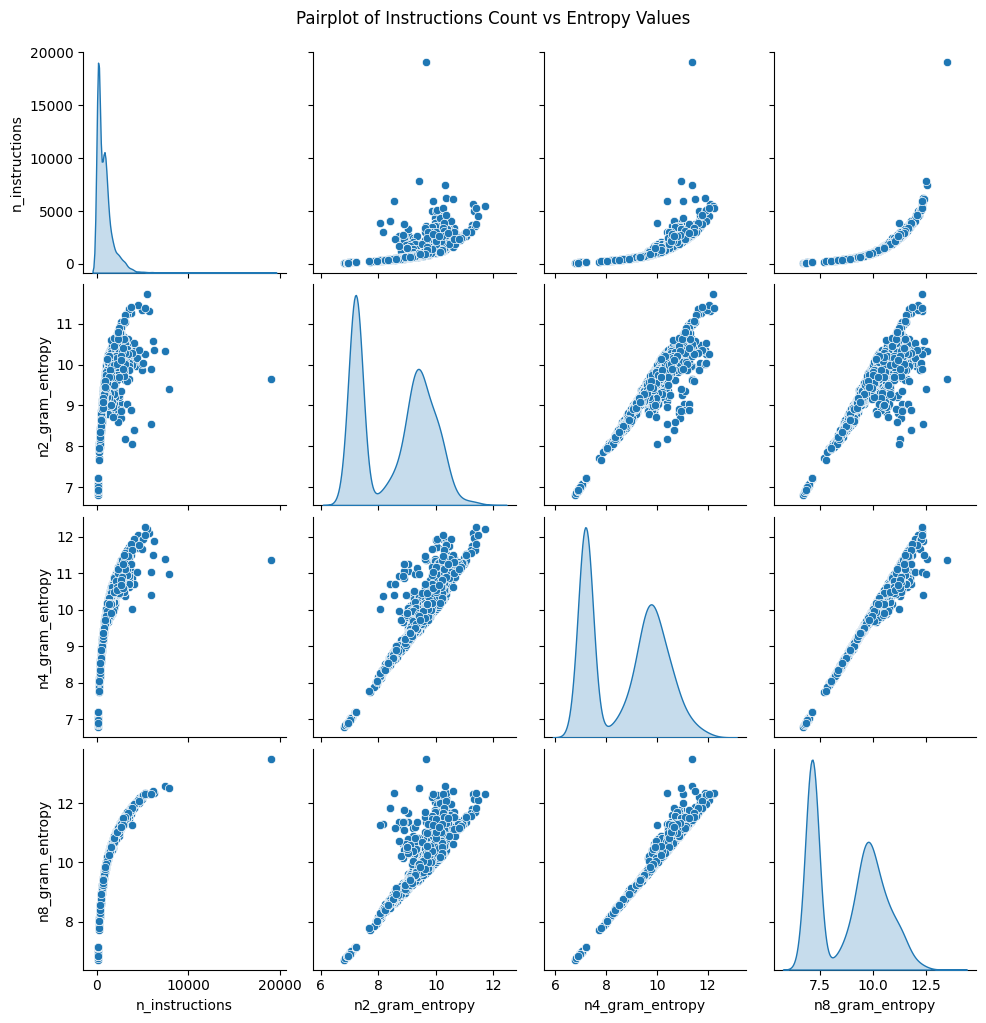

In [17]:

# Repeat for stripped instructions
df_file_level_entropy = read_and_merge_csv(
    'file_level_entropy.csv', df_metadata)

# Create a copy of the dataframe with only the relevant columns
plot_df = df_file_level_entropy[[
    'n_instructions'] + [f'n{n}_gram_entropy' for n in N_GRAMS]]

# Create pairplot using seaborn
sns.pairplot(plot_df, diag_kind='kde')
plt.suptitle('Pairplot of Instructions Count vs Entropy Values', y=1.02)
plt.show()

In [ ]:
# from IPython.display import display

# # Sample 5 files where is_transformed is False
# sampled_files_non_transformed = df_file_level_entropy[df_file_level_entropy['is_transformed'] == False].sample(
#     5)

# display(sampled_files_non_transformed)

# # Print the sampled files
# for file_name in sampled_files_non_transformed['file_name']:
#     file_path = os.path.join(directory_path, file_name)
#     with open(file_path, 'r') as file:
#         content = file.read()
#         print(f"Content of {file_name}:\n{content}\n")

KeyError: 'is_transformed'